In [1]:
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dense, Reshape, Input
from keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np

Code à implémenter

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(inputShape_: tuple, convLayers_=(64, 32), kernelShape_=(3,3), latentSpaceDim_=16):
        inputs = Input(shape=inputShape_)

        encoder = Sequential(layers=[inputs], name="encoder")
        for filt in convLayers_:
            #<debut code à enlever pour TP>
            encoder.add(Conv2D(filt, kernelShape_, strides=2, padding="same"))
            LeakyReLU(alpha=0.2)
            #</fin code à enlever pour TP>
        volumeSize = encoder.layers[-1].output_shape
        #<debut code à enlever pour TP>
        encoder.add(Flatten())
        encoder.add(Dense(latentSpaceDim_))
        #</fin code à enlever pour TP>

        bottleneck = Input(shape=(latentSpaceDim_,))

        decoder = Sequential(layers=[bottleneck], name="decoder")
        decoder.add(Dense(np.prod(volumeSize[1:]))) # reshape
        decoder.add(Reshape((volumeSize[1], volumeSize[2], volumeSize[3])))
        for filt in convLayers_[::-1]: #sens inverse
            #<debut code à enlever pour TP>
            decoder.add(Conv2DTranspose(filt, kernelShape_, strides=2, padding="same"))
            decoder.add(LeakyReLU(alpha=0.2))
            #</fin code à enlever pour TP>
        decoder.add(Conv2DTranspose(inputShape_[2], kernelShape_, padding="same"))
        decoder.add(Activation("sigmoid"))

        autoencoder = Sequential(layers=[inputs], name="autoencoder")
        #<debut code à enlever pour TP>
        autoencoder.add(encoder)
        autoencoder.add(decoder)
        #</fin code à enlever pour TP>

        return autoencoder

In [3]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import functools as fct

Code de test, il n'est pas nécéssaire de modifier ce code.

Loading MNIST
Epoch 1/3
1875/1875 [==============================] - 23s 13ms/step - loss: 0.0681 - val_loss: 0.0475
Epoch 2/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0376 - val_loss: 0.0314
Epoch 3/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0301 - val_loss: 0.0291


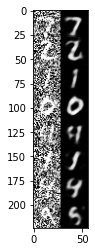

In [4]:
# initialize the number of epochs to train for and batch size
EPOCH = 3
BATCH_SIZE = 32

print("Loading MNIST")
(Xtr, _), (Xte, _) = mnist.load_data()

#les données sont en noir et blanc, et de dimension 28*28, 
#il faut donc rajouter une dim pour être en 28*28*1
Xtr = np.expand_dims(Xtr, axis=-1).astype("float32")
Xte = np.expand_dims(Xte, axis=-1).astype("float32")

# xtrain et xtest compris entre 0 et 1
Xtr /= 255.0
Xte /= 255.0

# Création des version noisy de xtrain et xtest
trNoise = np.random.normal(loc=0.5, scale=0.5, size=Xtr.shape)
teNoise = np.random.normal(loc=0.5, scale=0.5, size=Xte.shape)
XtrNoisy = np.clip(Xtr + trNoise, 0, 1)
XteNoisy = np.clip(Xte + teNoise, 0, 1)

autoencoder = ConvAutoencoder.build((28, 28, 1), kernelShape_=(3,3))
autoencoder.compile(loss="mse", optimizer=Adadelta(learning_rate=0.5))
autoencoder.fit(
	x=XtrNoisy, 
	y=Xtr,
	validation_data=(XteNoisy, Xte),
	epochs=EPOCH,
	batch_size=BATCH_SIZE
)

denoisedTest = autoencoder.predict(XteNoisy)

outputs = fct.reduce(
	lambda acc,val: np.vstack((
		acc, 
		np.hstack(((XteNoisy[val] * 255).astype("uint8"), (denoisedTest[val] * 255).astype("uint8")))
	)),
	range(1,8),
	np.hstack(((XteNoisy[0] * 255).astype("uint8"), (denoisedTest[0] * 255).astype("uint8")))
)

plt.imshow(outputs, cmap='gray', vmin=0, vmax=255)
plt.show()